<img align='left' alt='ESO Logo' src='http://archive.eso.org/i/esologo.png'>  

# &nbsp; ESO Science Archive Programmatic: HOWTOs

## HOW TO obtain data given parameters extracted from an ESO catalogue

The ESO Archive provides access to reduced or fully calibrated data sets, and derived catalogs, that were contributed by PIs of ESO programmes or produced by ESO (using ESO calibration pipelines with the best available calibration data), and then integrated into the ESO Science Archive Facility (see for instance the [ESO catalogue facility](https://www.eso.org/qi/) and the [Archive Science Portal](http://archive.eso.org/scienceportal/home) web-pages).

A powerful way to access this data is the so-called [_programmatic access_](http://archive.eso.org/programmatic/#TAP) via the `tap_cat` and `tap_obs` services. `archive_catalogues` and `archive_observations` are python wrappers part of the un-official [ESOAsg package](https://github.com/EmAstro/ESOAsg). These are built to facilitate the integration of the ESO archive tools within your python environment.

**Usage**: You can access this file as an interactive jupyter notebook, which you can download and run on your machine [(instructions)](https://jupyter.org/install). To interact with the jupyter notebook (if you have download it): move up and down the various cells using the arrow keys, execute the code by pressing CTRL+ENTER; you can also modify the code and execute it at will.

**Version**: Please note that this notebook uses Python version 3.9.13 and Jupyter Notebook version 6.4.10. Compatibility with other versions cannot be guaranteed.

**Authors**: Emanuele Paolo Farina & Ashley Thomas Barnes

---
## <a id='imports'>0. Imports - inc. ESOAsg package</a>

In [1]:
from ESOAsg import archive_observations # ESO Archive Observations
from ESOAsg import archive_catalogues # ESO Archive Catalogues

from astropy.coordinates import SkyCoord # Astropy coordinates
from astropy.io import fits # Astropy FITS files
import astropy.constants as const # Astropy constants
import astropy.units as u # Astropy units
import matplotlib.pyplot as plt # Matplotlib
import numpy as np # Numpy
import os # OS
from PyAstronomy import pyasl # PyAstronomy - used for Baricentric correction if not in header

# Set the default font size and weight for plots
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.dpi'] = 200

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


---
## <a id='Check catalogue'>1. Get all data from the VVVX survey catalogues </a>

In this example we will show how to get ... 

### <a id='query_vvvx'>1.1  Query the VVVX SOURCE catalogue </a>

To begin, you need to know the name of the table where the information are stored. For this, you can either check the [query interface webpage](https://www.eso.org/qi/) or you can obtain an astropy table of all catalogues (most recent versions only) using:
```python
archive_catalogues.all_catalogues_info(all_versions=False)
```

In [2]:
all_catalogues = archive_catalogues.all_catalogues_info(all_versions=False) # Get all the available catalogues
all_catalogues['collection', 'table_name', 'instrument', 'number_rows', 'number_columns'].show_in_notebook() # Show the available catalogues in a Jupyter notebook

         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


idx,collection,table_name,instrument,number_rows,number_columns
0,1101.A-0127,AMUSED_MAIN_SOURCE_CAT_V1,MUSE,2221,312
1,195.B-0283,GNS_catalogue_V1,HAWKI,3277646,27
2,196.D-0214,EREBOS_RV_cat_fits_V1,FORS2,359,6
3,196.D-0214,EREBOS_cat_fits_V1,FORS2,9,6
4,AMBRE,AMBRE_HARPS_V1,HARPS,126688,27
5,AMBRE,AMBRE_UVES_V1,UVES,51897,33
6,AMBRE,AMBRE_V1,FEROS,18618,33
7,ATLASGAL,ATLASGAL_V1,APEXBOL,10861,10
8,FDS,FDS_SourceCatalogue_V1,OMEGACAM,3112605,50
9,GAIAESO,GES_2021_VRAD,MULTI,110762,14


<!-- Now `all_catalogues` contains all the latest version of the catalogues currently present at ESO and you can now look for that `table_name` associated with the `VVVX` collection: -->

In [3]:
all_catalogues_vvv = all_catalogues[all_catalogues['collection'] == 'VVVX'] # Get all the VVVX catalogues
all_catalogues_vvv['collection', 'table_name', 'title', 'number_rows', 'number_columns', 'version'].show_in_notebook(show_row_index=False, display_length=6)

         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


collection,table_name,title,number_rows,number_columns,version
VVVX,VVVX_VIRAC_V2_LC,VIRAC2 time series,95768366366,22,1
VVVX,VVVX_VIRAC_V2_OBS,VIRAC2 observation details,197423,16,1
VVVX,VVVX_VIRAC_V2_REJECTED_LC,VIRAC2 time series - Rejected Sources,27419652812,22,1
VVVX,VVVX_VIRAC_V2_REJECTED_SOURCES,VIRAC2 source catalogue - Rejected Sources,844909545,87,1
VVVX,VVVX_VIRAC_V2_SOURCES,VIRAC2 source catalogue,545346533,87,1


We see that there are 5 VVVX catalogues: 
* ``VVVX_VIRAC_V2_SOURCES`` - Table with the sources
* ``VVVX_VIRAC_V2_REJECTED_SOURCES`` - Table with the rejected sources
* ``VVVX_VIRAC_V2_LC`` -Table with the light curves for the sources 
* ``VVVX_VIRAC_V2_REJECTED_SOURCES_LC`` - Table with the light curves for the rejected sources
* ``VVVX_VIRAC_V2_OBS`` - Table with the observation conditions 

In [4]:
tablename_vvvx_sources =                'VVVX_VIRAC_V2_SOURCES' # Table with the sources
tablename_vvvx_sources_rejected =       'VVVX_VIRAC_V2_REJECTED_SOURCES' # Table with the rejected sources
tablename_vvvx_sources_lc =             'VVVX_VIRAC_V2_LC' # Table with the light curves of the sources
tablename_vvvx_sources_lc_rejected =    'VVVX_VIRAC_V2_REJECTED_SOURCES_LC' # Table with the light curves of the rejected sources
tablename_vvvx_obs =                    'VVVX_VIRAC_V2_OBS' # Table with the observations conditions

In [5]:
columns_dict = {} # Dictionary to store the columns of the tables
for table_name in all_catalogues_vvv['table_name']:
    columns_dict[table_name] = archive_catalogues.columns_info(tables=table_name)

# Show the columns of the VVVX_VIRAC_V2_SOURCES table
columns_dict[tablename_vvvx_sources].show_in_notebook(show_row_index=False, display_length=5) 

         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


table_name,column_name,ucd,datatype,description,unit
VVVX_VIRAC_V2_SOURCES,sourceid,meta.id;meta.main,BIGINT,unique source identified,
VVVX_VIRAC_V2_SOURCES,astfit_epochs,meta.number;time.epoch,SMALLINT,number of epochs used for astrometric solution,
VVVX_VIRAC_V2_SOURCES,astfit_params,meta.number,SMALLINT,number of astrometric solution parameters,
VVVX_VIRAC_V2_SOURCES,duplicate,meta.code,SMALLINT,flag indicating a likely duplicate entry,
VVVX_VIRAC_V2_SOURCES,ref_epoch,time.epoch,DOUBLE,astrometric reference epoch,yr
VVVX_VIRAC_V2_SOURCES,ra,pos.eq.ra;meta.main,DOUBLE,right ascension,deg
VVVX_VIRAC_V2_SOURCES,ra_error,stat.error;pos.eq.ra,DOUBLE,uncertainty on right ascension,mas
VVVX_VIRAC_V2_SOURCES,de,pos.eq.dec;meta.main,DOUBLE,declination,deg
VVVX_VIRAC_V2_SOURCES,de_error,stat.error;pos.eq.dec,DOUBLE,uncertainty on declination,mas
VVVX_VIRAC_V2_SOURCES,parallax,pos.parallax.trig,DOUBLE,trigonometric parallax,mas


Now lets get a subset of the VVVX_VIRAC_V2_SOURCES

In [6]:
selected_columns = ['sourceid', 'ra', 'de', 'phot_ks_mean_mag', 'phot_z_mean_mag', 'phot_j_mean_mag', 'phot_ks_n_epochs'] # Define the columns to be selected
table_vvvx_sources = archive_catalogues.get_catalogues(tables=tablename_vvvx_sources, columns=selected_columns, top=1e2, order_by='phot_ks_n_epochs', order='descending') 
# table_vvvx_sources.show_in_notebook(show_row_index=False, display_length=5) # Show the columns of the table in a Jupyter notebook

[INFO]    :: The query to VVVX_VIRAC_V2_SOURCES returned 100 entries (with a limit set to maxrec=545346533)


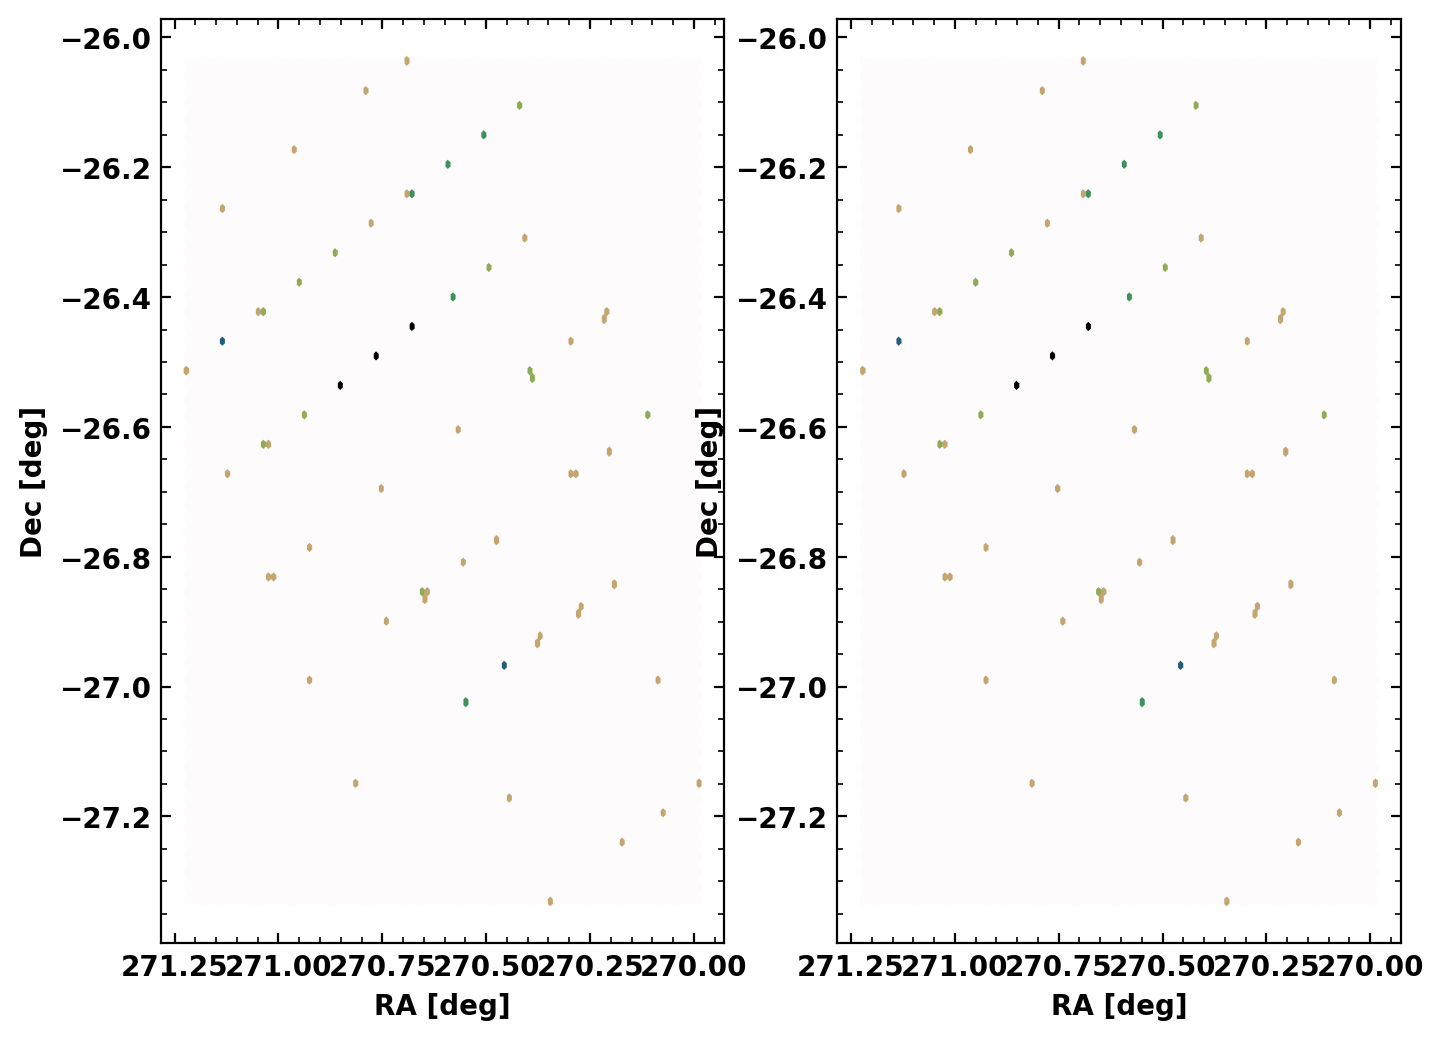

In [7]:
fig = plt.figure(figsize=(8, 6)) # Create a figure

ax1 = fig.add_subplot(121) # Add a subplot with Mollweide projection
ax2 = fig.add_subplot(122) # Add a subplot with Mollweide projection

ax_plot = ax1.hexbin(table_vvvx_sources['ra'], table_vvvx_sources['de'], cmap='gist_earth_r', linewidths=0.1)
ax_plot = ax2.hexbin(table_vvvx_sources['ra'], table_vvvx_sources['de'], cmap='gist_earth_r', linewidths=0.1)

for ax in [ax1, ax2]:
    ax.set_xlabel('RA [deg]') # Set the x-axis label
    ax.set_ylabel('Dec [deg]') # Set the y-axis label
    ax.invert_xaxis() # Flip the x-axis

Text(0, 0.5, '$Z - J$')

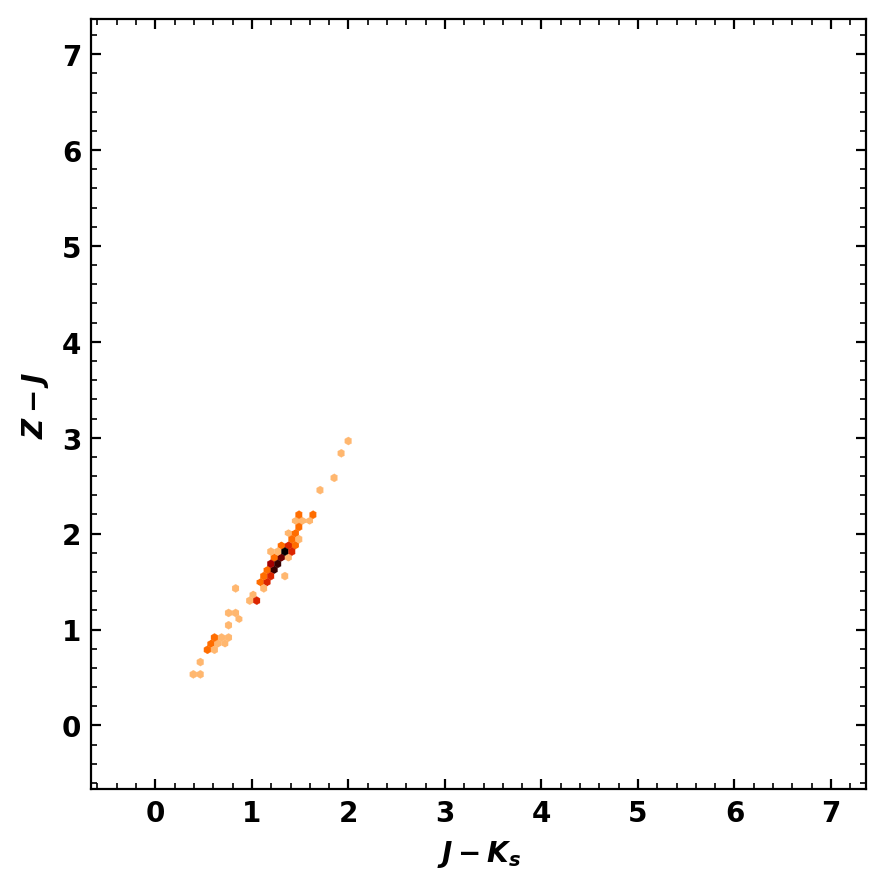

In [8]:
fig = plt.figure(figsize=(5, 5)) # Create a figure
ax = fig.add_subplot(111) # Add a subplot with Mollweide projection

jk = table_vvvx_sources['phot_j_mean_mag'] - table_vvvx_sources['phot_ks_mean_mag']
zj = table_vvvx_sources['phot_z_mean_mag'] - table_vvvx_sources['phot_j_mean_mag']

ax_plot = ax.hexbin(
    jk,  
    zj, 
    cmap='gist_heat_r',  # Color map for the hexbin
    linewidths=0.1,  # Thin lines around hexagons for clarity
    extent=[-0.3, 7, -0.3, 7]  # Set the limits of the plot
)

ax.set_xlabel(r'$J - K_s$') # Set the x-axis label
ax.set_ylabel(r'$Z - J$') # Set the y-axis label 

# ax.set_xlim(-0.3, 2.5)  # Set x-axis limits
# ax.set_ylim(-0.3, 2.3)  # Set y-axis limits

In [13]:
table_vvvx_source_lc = archive_catalogues.get_catalogues(tables=tablename_vvvx_sources_lc, conditions_dict={'sourceid': table_vvvx_sources['sourceid'][0]}, maxrec=3000)
table_vvvx_source_lc.show_in_notebook(show_row_index=False, display_length=5) # Show the columns of the table in a Jupyter notebook

[INFO]    :: The query to VVVX_VIRAC_V2_LC returned 2199 entries (with a limit set to maxrec=3000)
         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


ambiguous_match,ast_res_chisq,catid,chi,cnf_ctr,de,edec,emag,era,ex,ext,ey,filter,mag,mjdobs,objtype,phot_flag,ra,seeing,sourceid,x,y
,,,,,deg,mas,mag,mas,pixel,,pixel,,mag,d,,,deg,arcsec,,pixel,pixel
0,0.1307122,187088,5.1,46,-26.3554601184468,15.904878370275494,0.035092622,16.318169624584193,0.027,9,0.025,H,13.4612665,55298.31300413,1,0,270.49200897562656,0.62784206867218,13280261001465,1982.863,2076.585
0,0.0018257938,187139,3.64,45,-26.355460607117074,13.495730220765534,0.030322365,13.76496327562404,0.019,10,0.018,H,13.461486,55298.31331039,1,0,270.49201057055427,0.620375573635101,13280261001465,30.499,2072.517
0,0.7880243,187137,5.59,49,-26.3554622412009,17.114748835790753,0.038288627,18.219644394836376,0.03,10,0.027,H,13.452752,55298.313617089996,1,0,270.4920153459902,0.60920774936676,13280261001465,1000.193,2070.446
0,0.398045,187094,1.81,95,-26.355459633741113,6.41208978027688,0.014833036,6.346351963400844,0.01,10,0.009,H,13.456793,55298.31393668,1,0,270.49201049982815,0.61847311258316,13280261001465,1001.922,133.993
0,0.1626892,187085,5.27,44,-26.355460547741128,14.353592036967232,0.034902528,15.025034184226561,0.023,10,0.022,H,13.467157,55298.31424292,1,0,270.4920125202271,0.61762934923172,13280261001465,32.868,130.445
0,0.8928711,187077,3.22,96,-26.355457548465445,12.277162427629397,0.026312081,12.675097756880602,0.018,9,0.017,H,13.414548,55298.31455712,1,0,270.49201109345915,0.592211961746216,13280261001465,1988.449,137.852
0,0.21752629,60990,2.89,46,-26.35546207318752,10.372829924586124,0.028565364,11.264965595159973,0.019,9,0.018,Ks,13.013536,55298.31520528,1,0,270.49201038199357,0.5920019715,13280261001465,1983.391,2075.465
0,0.13330424,60991,3.67,46,-26.35546102173381,13.150382342263937,0.035171546,12.810710960861078,0.021,10,0.021,Ks,13.012512,55298.31551255,1,0,270.49201207543933,0.612577068,13280261001465,30.542,2072.267
0,2.6504703,60992,1.75,49,-26.355460048902252,5.3998414464428075,0.016182667,5.774059889630923,0.01,10,0.009,Ks,12.991611,55298.31581923,1,0,270.4920134481659,0.5998464315,13280261001465,1000.389,2070.258


In [10]:
n = 25
table_vvvx_source_lc_arr = ['']*n
for i in range(n):
    table_vvvx_source_lc_arr[0] = archive_catalogues.get_catalogues(tables=tablename_vvvx_sources_lc, conditions_dict={'sourceid': table_vvvx_sources['sourceid'][i]}, maxrec=3000)

[INFO]    :: The query to VVVX_VIRAC_V2_LC returned 2199 entries (with a limit set to maxrec=3000)
[INFO]    :: The query to VVVX_VIRAC_V2_LC returned 2195 entries (with a limit set to maxrec=3000)
[INFO]    :: The query to VVVX_VIRAC_V2_LC returned 2193 entries (with a limit set to maxrec=3000)
[INFO]    :: The query to VVVX_VIRAC_V2_LC returned 2200 entries (with a limit set to maxrec=3000)
[INFO]    :: The query to VVVX_VIRAC_V2_LC returned 2195 entries (with a limit set to maxrec=3000)
[INFO]    :: The query to VVVX_VIRAC_V2_LC returned 2198 entries (with a limit set to maxrec=3000)
[INFO]    :: The query to VVVX_VIRAC_V2_LC returned 2196 entries (with a limit set to maxrec=3000)
[INFO]    :: The query to VVVX_VIRAC_V2_LC returned 2195 entries (with a limit set to maxrec=3000)
[INFO]    :: The query to VVVX_VIRAC_V2_LC returned 2198 entries (with a limit set to maxrec=3000)
[INFO]    :: The query to VVVX_VIRAC_V2_LC returned 2194 entries (with a limit set to maxrec=3000)
[INFO]    

TypeError: string indices must be integers

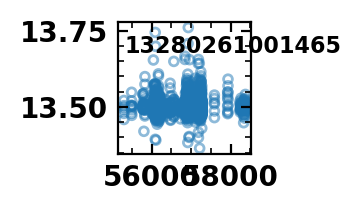

In [11]:
fig = plt.figure(figsize=(5, 5)) # Create a figure

for i in range(25):
    
    table_vvvx_source_lc = table_vvvx_source_lc_arr[i]

    ks_mask = table_vvvx_source_lc['filter'] == 'Ks'
    z_mask = table_vvvx_source_lc['filter'] == 'Z'
    j_mask = table_vvvx_source_lc['filter'] == 'J'
    h_mask = table_vvvx_source_lc['filter'] == 'H'

    ax = fig.add_subplot(5,5,i+1) 
    ax.scatter(table_vvvx_source_lc['mjdobs'][ks_mask], table_vvvx_source_lc['mag'][ks_mask], s=10, label='Ks', fc='none', ec='C0', alpha=0.5)
    ax.text(0.05, 0.9, f'{table_vvvx_sources["sourceid"][i]}', transform=ax.transAxes, fontsize=8, ha='left', va='top')